# Segment Anything implemented with Pytorch Lightning
Notebook author: Christian Kento Rasmussen (s204159@dtu.dk)

With credits to: Patrick Møller jensen (patmjen@dtu.dk)

This Notebook shows how to use the Segment-Anything model (SAM) from Meta Research

## Dependencies
Mostly Pytorch, Monai, and segment_anything


## Reference this work
Segment-Anything is a model from Meta Research, and the original paper can be found here: https://arxiv.org/abs/2304.02643

```bibtex
@misc{kirillov2023segment,
      title={Segment Anything}, 
      author={Alexander Kirillov and Eric Mintun and Nikhila Ravi and Hanzi Mao and Chloe Rolland and Laura Gustafson and Tete Xiao and Spencer Whitehead and Alexander C. Berg and Wan-Yen Lo and Piotr Dollár and Ross Girshick},
      year={2023},
      eprint={2304.02643},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}
```

## Setup

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pickle
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

### Setup of SAM

You can download SAM checkpoint from the [github repository](https://github.com/facebookresearch/segment-anything)

In [14]:
sam = sam_model_registry["vit_b"](
    checkpoint="methods/sam_checkpoints/sam_vit_b_01ec64.pth").cuda().eval()

mask_generator = SamAutomaticMaskGenerator(sam)

### Setup example data

Text(0.5, 1.0, 'Label Image')

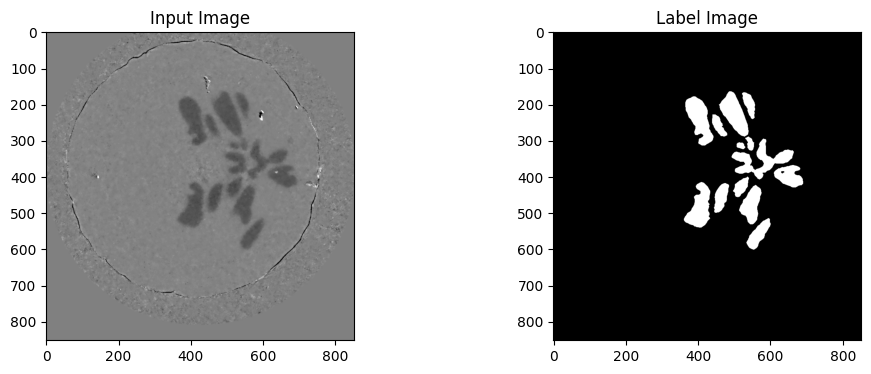

In [19]:
# Loads the data from a pickle file
with open('resources/img2d/data_10.pickle', 'rb') as f:
    data = pickle.load(f)
    im, lb, ms = data


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Input Image')
ax[1].imshow(lb, cmap='gray', alpha=1)
ax[1].set_title('Label Image')

### test of sam mask_generator

Text(0.5, 1.0, 'SAM mask_generator ouput on stan2020 image')

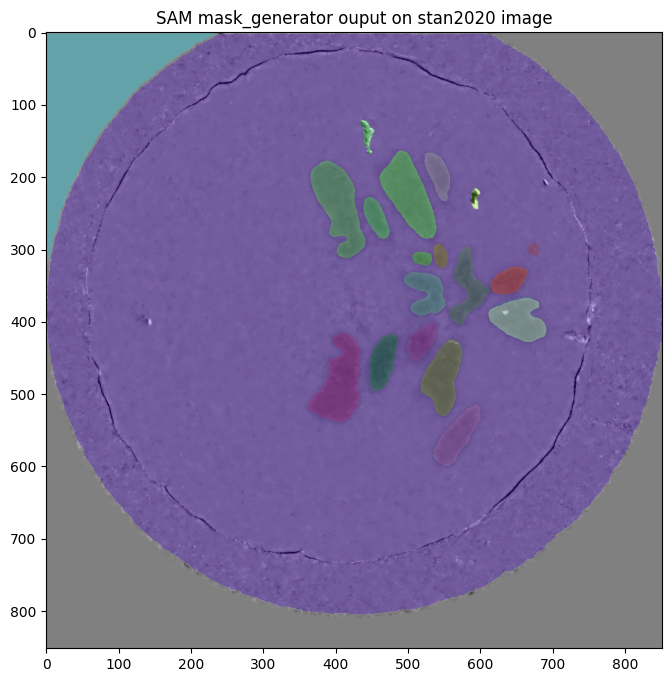

In [ ]:
def prep_im(im) -> np.ndarray:
    """
    Prepare an input image for use in a segmentation task.

    Args:
        im (numpy.ndarray): The input image.

    Returns:
        np.ndarray: The prepared image.
    """
    # If the input image has a data type of np.float32, convert it to np.uint8
    # and expand it to have three channels.
    if im.dtype == np.float32:
        im = (im * 255).astype(np.uint8)
    return im[..., None].repeat(3, axis=-1)


def create_segmentation_mask(annotations):
    """
    Create a segmentation mask image from a list of annotations.

    Args:
        annotations (list): The list of annotations in COCO format.

    Returns:
        numpy.ndarray: The segmentation mask image.
    """
    # If there are no annotations, return None.
    if len(annotations) == 0:
        return None

    # Sort the annotations by area in descending order.
    sorted_annotations = sorted(annotations, key=(
        lambda x: x['area']), reverse=True)

    # Create a new image with the same shape as original image
    # but with an additional fourth channel for transparency.
    mask_shape = sorted_annotations[0]['segmentation'].shape[:2] + (4,)
    segmentation_mask = np.ones(mask_shape)
    # sets transparancy to 0 for mask
    segmentation_mask[:, :, 3] = 0

    # For each annotation, generate a random color and set the corresponding pixels in
    # the image to that color with a transparency of 0.35.
    for annotation in sorted_annotations:
        segmentation = annotation['segmentation']
        color = np.concatenate([np.random.random(3), [0.35]])
        segmentation_mask[segmentation] = color

    return segmentation_mask


masks = mask_generator.generate(prep_im(im))
plt.figure(figsize=(8, 8))
plt.imshow(im, cmap='gray')
plt.imshow(create_segmentation_mask(masks))
plt.title('SAM mask_generator ouput on stan2020 image')

### Setup of SamPredictor (prompt)

In [ ]:
# Creating a sam predictor object and setting an image for segmentation
predictor = SamPredictor(sam)
predictor.set_image(prep_im(im))

### Prompt from point
The following code uses a single point as a prompt for the model to segment from.

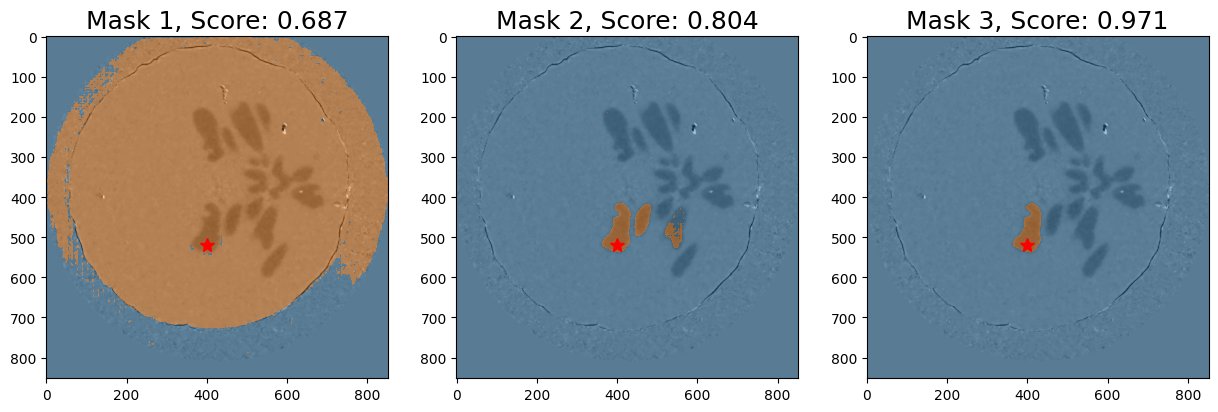

In [16]:
input_point = np.array([[400, 520]])
input_label = np.array([1])

# makes the prediction
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Visualization
cmap = ListedColormap([f'C{i}' for i in range(2)])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, (mask, score) in enumerate(zip(masks, scores)):
    ax = axs[i]
    ax.imshow(im, cmap='gray')
    ax.imshow(mask, cmap=cmap, alpha=0.4)
    ax.set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    ax.plot(input_point[0][0], input_point[0][1],
            marker='*', markersize=10, color='r')

plt.show()

### Prompt from bounding box

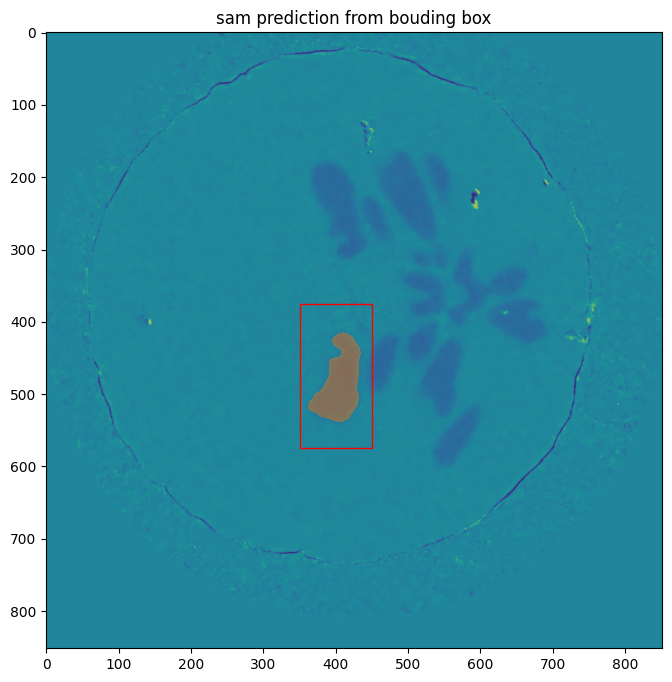

In [17]:
input_box = np.array([350, 375, 450, 575])

# makes the prediction
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)


# Visualization
x0, y0 = input_box[0], input_box[1]
w, h = input_box[2] - input_box[0], input_box[3] - input_box[1]

fig, ax = plt.subplots(figsize=(8, 8))
rect = plt.Rectangle((x0, y0), w, h, linewidth=1,
                     edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.imshow(im)
ax.imshow(masks[0], cmap=cmap, alpha=0.4)
ax.set_title('sam prediction from bouding box')
plt.show()

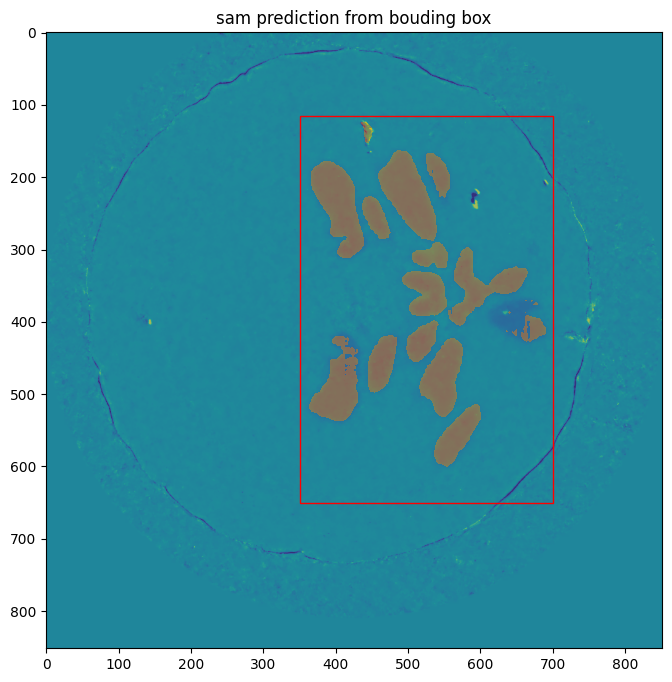

In [18]:
input_box = np.array([350, 115, 700, 650])
# makes the prediction
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)


# Visualization
x0, y0 = input_box[0], input_box[1]
w, h = input_box[2] - input_box[0], input_box[3] - input_box[1]

fig, ax = plt.subplots(figsize=(8, 8))
rect = plt.Rectangle((x0, y0), w, h, linewidth=1,
                     edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.imshow(im)
ax.imshow(masks[0], cmap=cmap, alpha=0.4)
ax.set_title('sam prediction from bouding box')
plt.show()